In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.stats.multitest import multipletests

In [2]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

In [3]:
file_path = '../Data/Processed/video_rating.csv'

In [4]:
df = pd.read_csv(file_path, header=0, index_col=[0, 1])

In [5]:
df.dtypes

start_time                     object
end_time                       object
wander_speed                  float64
wander_roundness              float64
wander_roundness_effective    float64
wander_cycle_rate             float64
blink_temperature             float64
blink_slope                   float64
blink_cycle_rate              float64
beep_pitch                    float64
beep_slope                    float64
beep_cycle_rate               float64
joy_intensity                 float64
sadness_intensity             float64
fear_intensity                float64
anger_intensity               float64
disgust_intensity             float64
surprise_intensity            float64
other_emotion                  object
other_intensity               float64
pleasure                        int64
arousal                         int64
dominance                       int64
appraisal                      object
dtype: object

In [6]:
df.fillna(0, inplace=True)

In [7]:
df.drop(columns=['other_emotion', 'other_intensity', 'wander_roundness_effective'], inplace=True)

In [8]:
include_wander_effective_roundness = False

In [9]:
if include_wander_effective_roundness:
    independent_variables = ['wander_speed', 'wander_roundness', 'wander_roundness_effective', 'wander_cycle_rate', 'blink_temperature', 'blink_slope', 'blink_cycle_rate', 'beep_pitch', 'beep_slope', 'beep_cycle_rate']
else:
    independent_variables = ['wander_speed', 'wander_roundness', 'wander_cycle_rate', 'blink_temperature', 'blink_slope', 'blink_cycle_rate', 'beep_pitch', 'beep_slope', 'beep_cycle_rate']

In [10]:
continuous_independent_variables = independent_variables.copy()
continuous_independent_variables.remove('blink_slope')
continuous_independent_variables.remove('beep_slope')

In [11]:
# Define the list of rating column
intensity_columns = ['joy_intensity', 'sadness_intensity', 'anger_intensity', 'fear_intensity', 'disgust_intensity', 'surprise_intensity']
sam_columns = ['pleasure', 'arousal', 'dominance']
dependent_variables = intensity_columns + sam_columns + ['appraisal']
dependent_numeric_variables = intensity_columns + sam_columns

In [12]:
num_independent_variables = len(independent_variables)
num_dependent_numeric_variables = len(dependent_numeric_variables)

In [13]:
df[intensity_columns] = df[intensity_columns].astype(float)
df[sam_columns] = df[sam_columns].astype(float)

In [14]:
df

start_time      end_time  wander_speed  \
participant_id           video_id                                             
5588b2bffdf99b7a7714efd1 22        5/8/24 22:59  5/8/24 23:40     62.775115   
                         43        5/8/24 22:59  5/8/24 23:40     61.110970   
                         50        5/8/24 22:59  5/8/24 23:40     46.017272   
                         84        5/8/24 22:59  5/8/24 23:40     78.659842   
                         125       5/8/24 22:59  5/8/24 23:40     74.946312   
...                                         ...           ...           ...   
6613a814a0c2d6cb21da8ef8 279       5/8/24 21:33  5/8/24 22:09     30.321874   
                         387       5/8/24 21:33  5/8/24 22:09     52.342993   
                         423       5/8/24 21:33  5/8/24 22:09     37.922254   
                         467       5/8/24 21:33  5/8/24 22:09     49.408758   
                         478       5/8/24 21:33  5/8/24 22:09     55.832759   

                                   wander_roundness  wander_cycle_rate  \
participant_id           video_id                                        
5588b2bffdf99b7a7714efd1 22                0.688911           3.862264   
                         43                0.352980           4.637822   
                         50                0.530403           3.425497   
                         84                0.963506           4.025686   
                         125               0.498299           3.467634   
...                                             ...                ...   
6613a814a0c2d6cb21da8ef8 279               0.203517           5.904459   
                         387               0.496135           2.325440   
                         423               0.283549           1.888757   
                         467               0.420447           4.809581   
                         478               0.652202           2.657507   

                                   blink_temperature  blink_slope  \
participant_id           video_id                                   
5588b2bffdf99b7a7714efd1 22                 0.504496          0.0   
                         43                 0.929641          0.0   
                         50                 0.943638          1.0   
                         84                 0.931626          0.0   
                         125                0.330719         -1.0   
...                                              ...          ...   
6613a814a0c2d6cb21da8ef8 279                0.464465         -1.0   
                         387                0.086675          1.0   
                         423                0.400462          0.0   
                         467                0.447571         -1.0   
                         478                0.231250          0.0   

                                   blink_cycle_rate  beep_pitch  beep_slope  \
participant_id           video_id                                             
5588b2bffdf99b7a7714efd1 22                4.403772  123.816519         0.0   
                         43                3.738390  773.537894         0.0   
                         50                2.511475  598.384259         1.0   
                         84                0.646983  689.681266         0.0   
                         125               5.915387  764.680016         0.0   
...                                             ...         ...         ...   
6613a814a0c2d6cb21da8ef8 279               5.540890  744.226868         0.0   
                         387               3.799604  586.635677         0.0   
                         423               2.939068  105.036834         1.0   
                         467               1.632404  687.165981         0.0   
                         478               0.506117  517.980755        -1.0   

                                   ...  joy_intensity  sadness_intensity  \
participant_id           video_id  ...      

In [15]:
datetime_format = '%m/%d/%y %H:%M'

df["start_time"] = pd.to_datetime(df["start_time"], format=datetime_format)
df["end_time"] = pd.to_datetime(df["end_time"], format=datetime_format)

In [16]:
df.dtypes

start_time            datetime64[ns]
end_time              datetime64[ns]
wander_speed                 float64
wander_roundness             float64
wander_cycle_rate            float64
blink_temperature            float64
blink_slope                  float64
blink_cycle_rate             float64
beep_pitch                   float64
beep_slope                   float64
beep_cycle_rate              float64
joy_intensity                float64
sadness_intensity            float64
fear_intensity               float64
anger_intensity              float64
disgust_intensity            float64
surprise_intensity           float64
pleasure                     float64
arousal                      float64
dominance                    float64
appraisal                     object
dtype: object

In [17]:
# Save the processed data to a new CSV file
df.to_csv('../Data/Processed/rating_numeric.csv', index=True)

In [18]:
df[dependent_numeric_variables].describe()

,joy_intensity,sadness_intensity,anger_intensity,fear_intensity,disgust_intensity,surprise_intensity,pleasure,arousal,dominance
count,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000
mean,1.720570,1.555696,1.125949,1.461709,0.875949,1.480380,4.341772,5.107595,4.447468
std,1.584615,1.515374,1.335216,1.502069,1.172030,1.406671,2.343343,2.112492,2.145638
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,3.000000
50%,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,4.000000,5.000000,5.000000
75%,3.000000,3.000000,2.000000,3.000000,1.000000,3.000000,6.000000,7.000000,6.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.000000


In [19]:
titles = {'wander_speed': 'Wander Speed', 'wander_roundness': 'Wander Roundness', 'wander_roundness_effective': 'Wander Effective Roundness', 'wander_cycle_rate': 'Wander Cycle Rate', 
          'blink_temperature': 'Blink Temperature', 'blink_slope': 'Blink Slope', 'blink_cycle_rate': 'Blink Cycle Rate', 
          'beep_pitch': 'Beep Pitch', 'beep_slope': 'Beep Slope', 'beep_cycle_rate': 'Beep Cycle Rate',
          'joy_intensity': 'Joy Intensity', 'sadness_intensity': 'Sadness Intensity', 'anger_intensity': 'Anger Intensity', 
          'fear_intensity': 'Fear Intensity', 'disgust_intensity': 'Disgust Intensity', 'surprise_intensity': 'Surprise Intensity',
          'pleasure': 'Pleasure', 'arousal': 'Arousal', 'dominance': 'Dominance'}

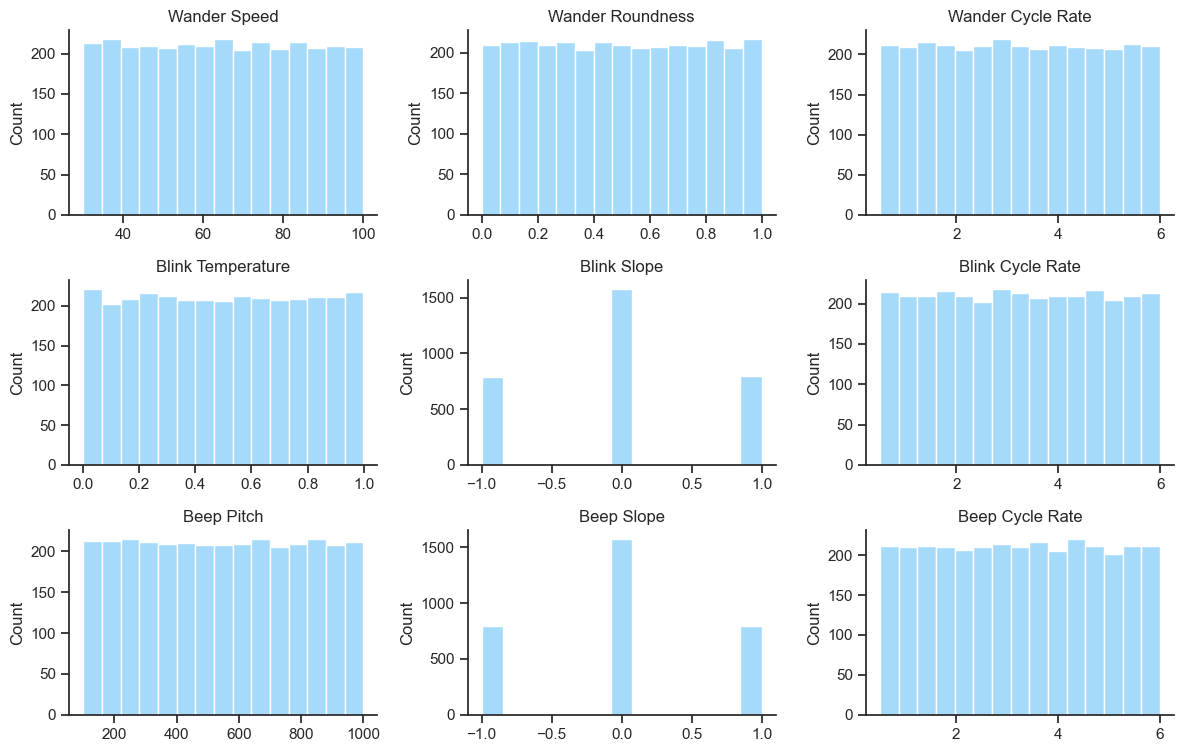

In [20]:
fig, axes = plt.subplots(3, 3, figsize=(12, 8))

for ax, independent_variable in zip(axes.flatten(), independent_variables):
    # Create the histplot in the specified subplot
    sns.histplot(data=df, x=independent_variable, ax=ax, color='lightskyblue')
    ax.set_title(titles[independent_variable])
    ax.set_xlabel('')
    ax.set_ylabel('Count')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

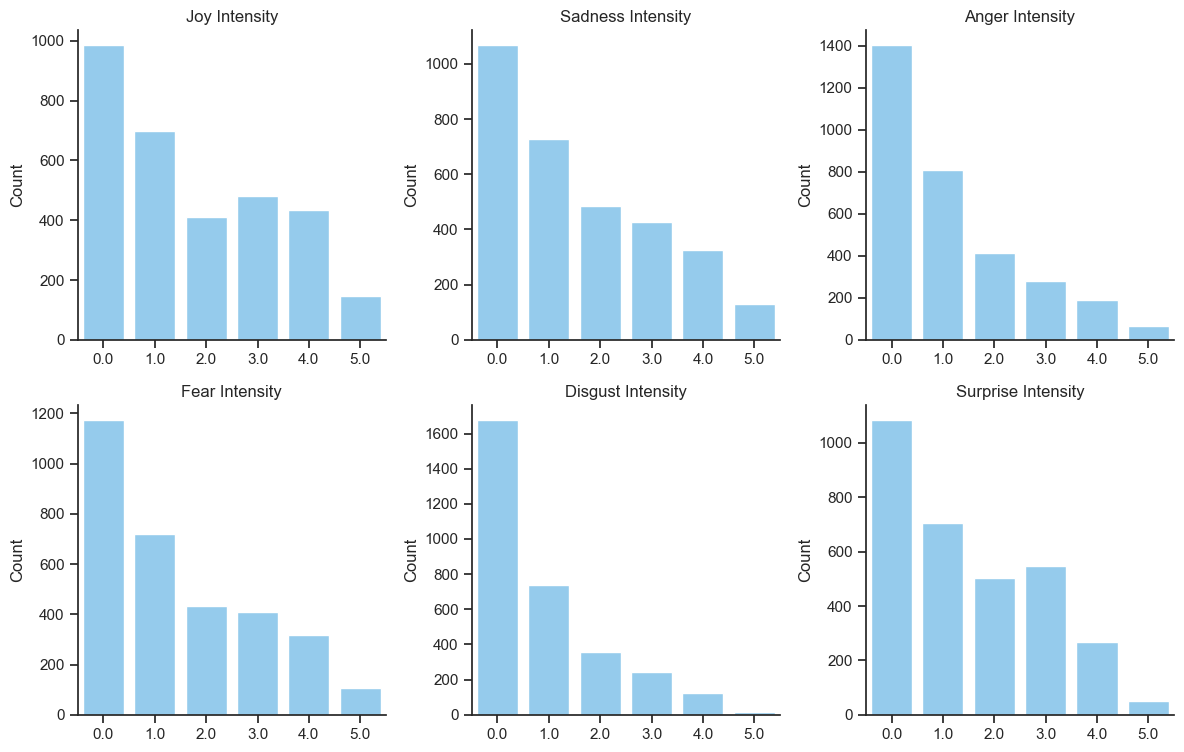

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for ax, dependent_variable in zip(axes.flatten(), intensity_columns):
    # Create the catplot in the specified subplot
    sns.countplot(data=df, x=dependent_variable, ax=ax, color='lightskyblue')
    ax.set_title(titles[dependent_variable])
    ax.set_xlabel('')
    ax.set_ylabel('Count')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

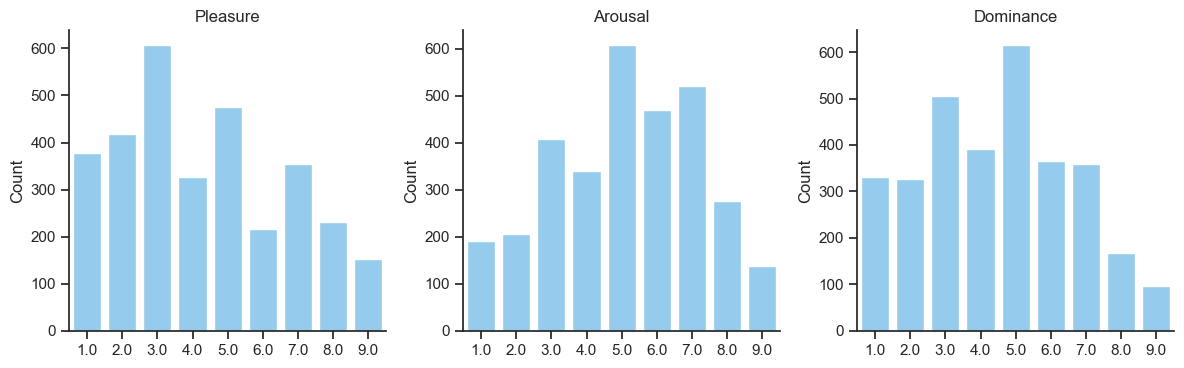

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, dependent_variable in zip(axes.flatten(), sam_columns):
    # Create the catplot in the specified subplot
    sns.countplot(data=df, x=dependent_variable, ax=ax, color='lightskyblue')
    ax.set_title(titles[dependent_variable])
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

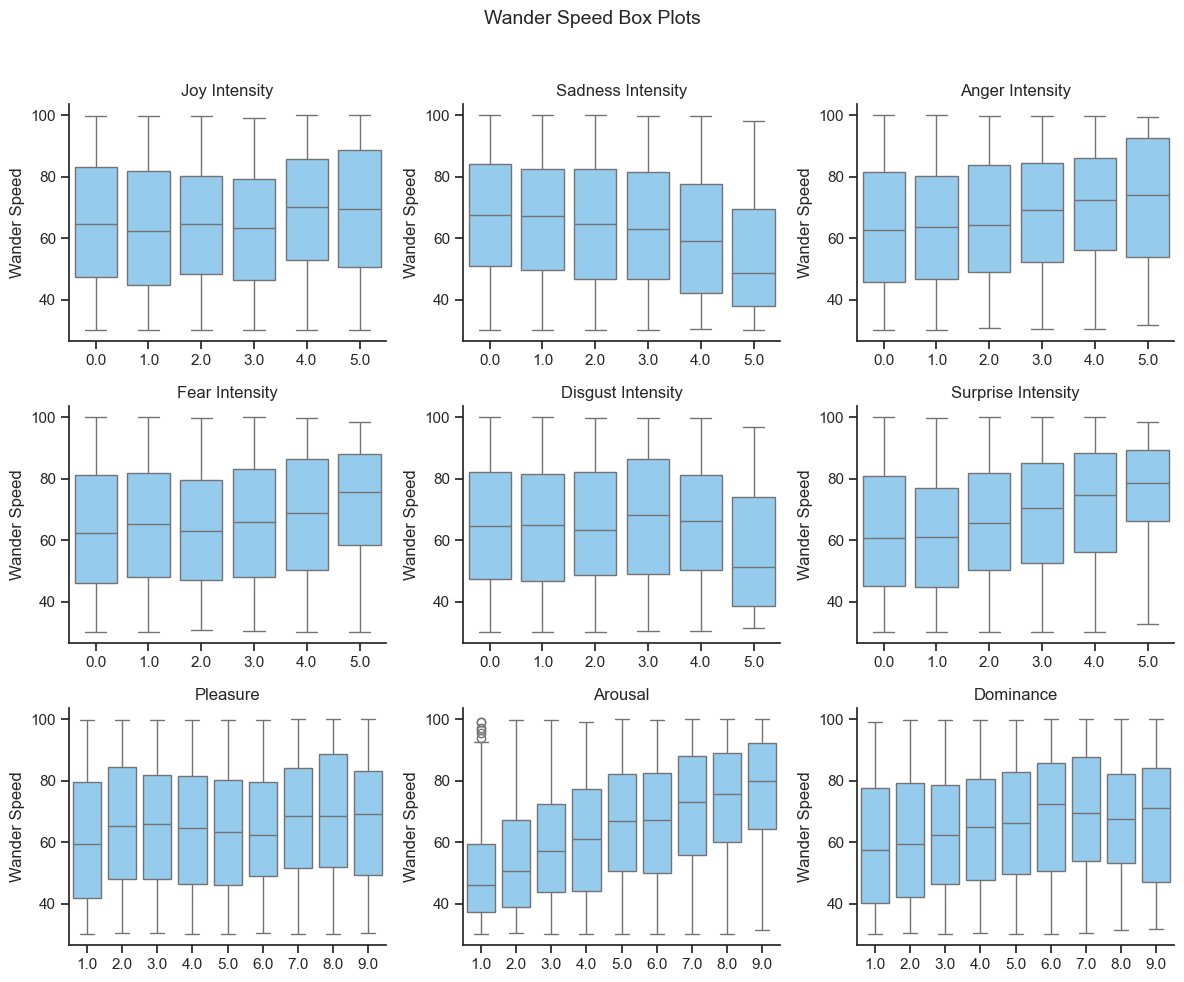

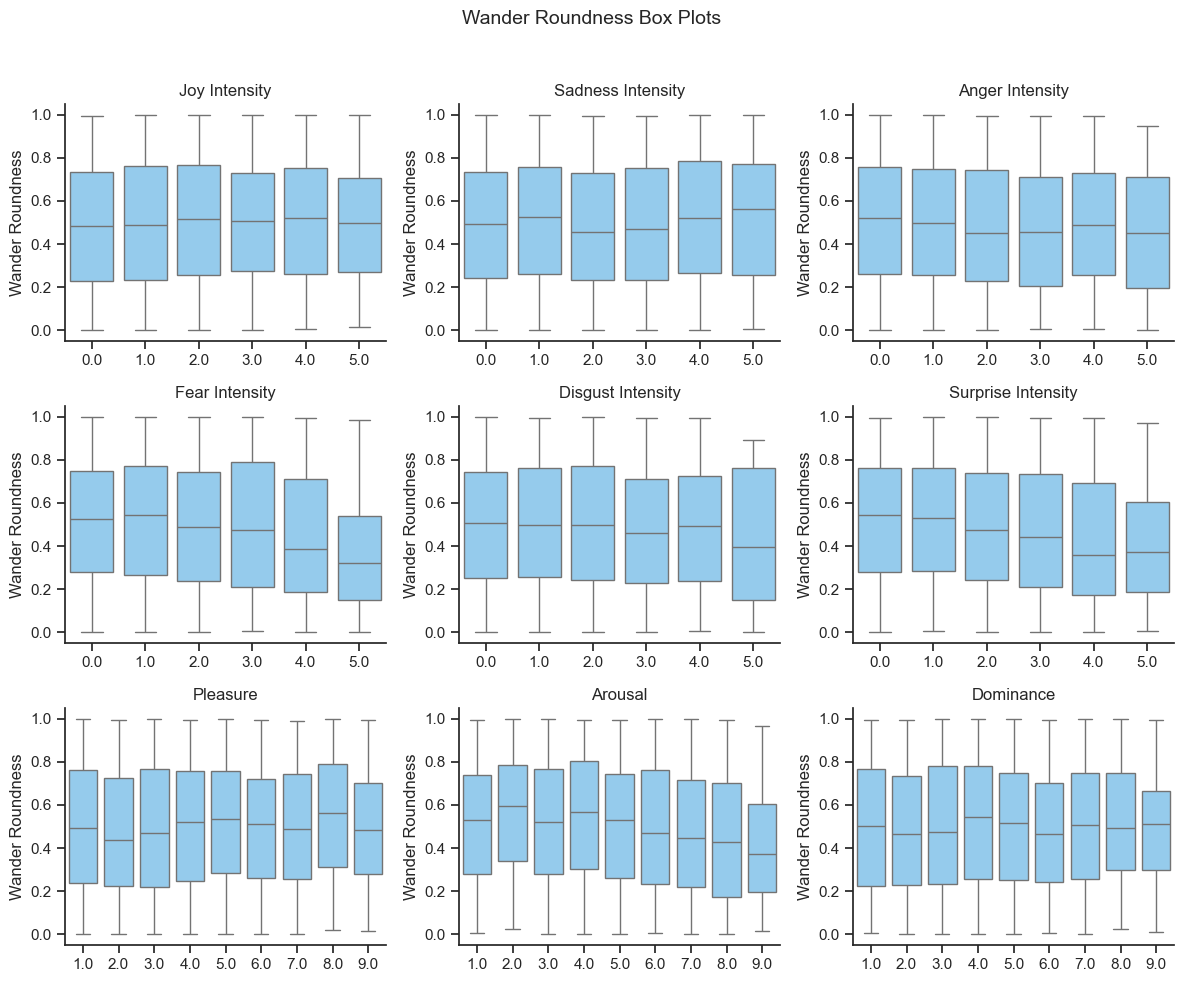

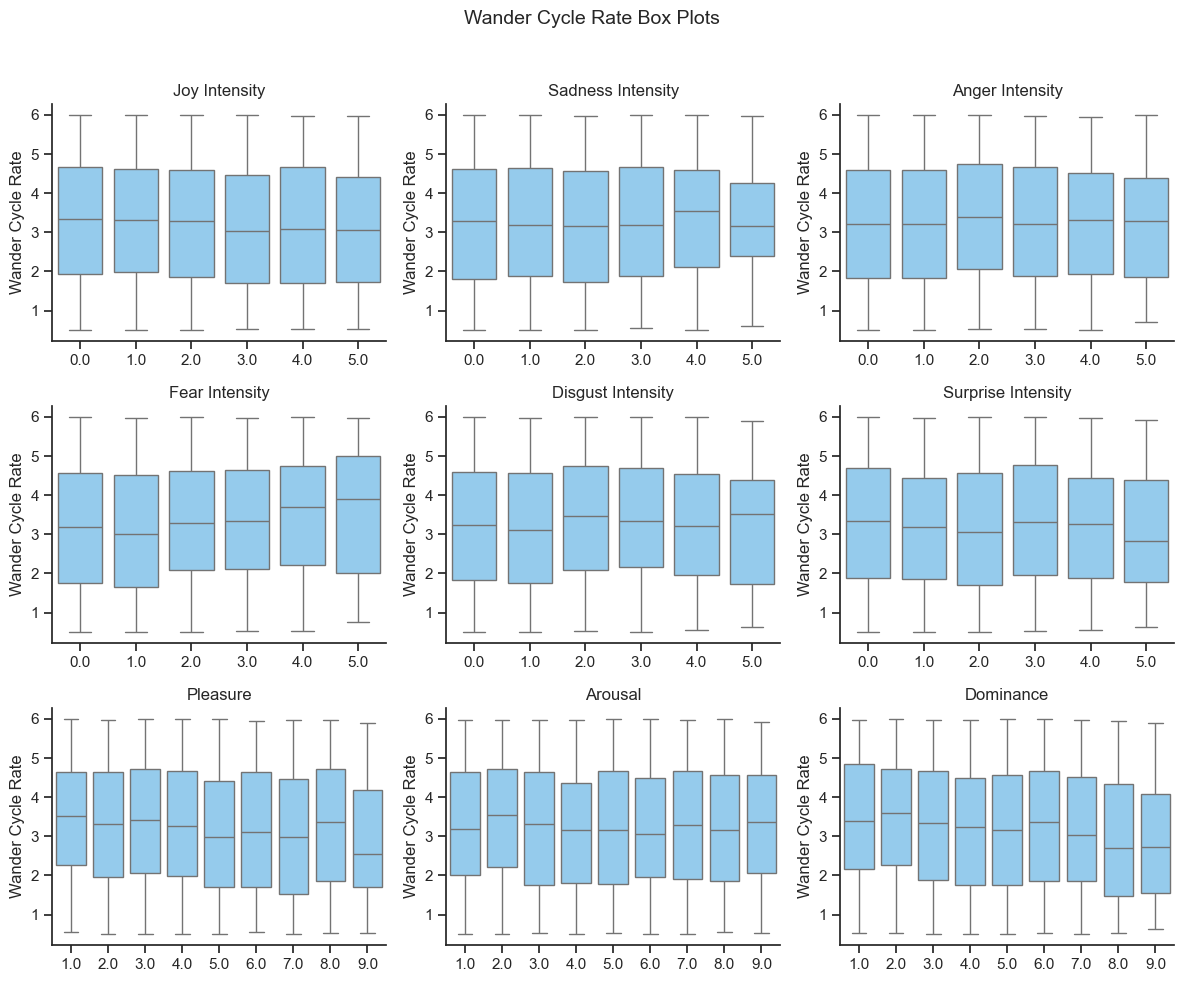

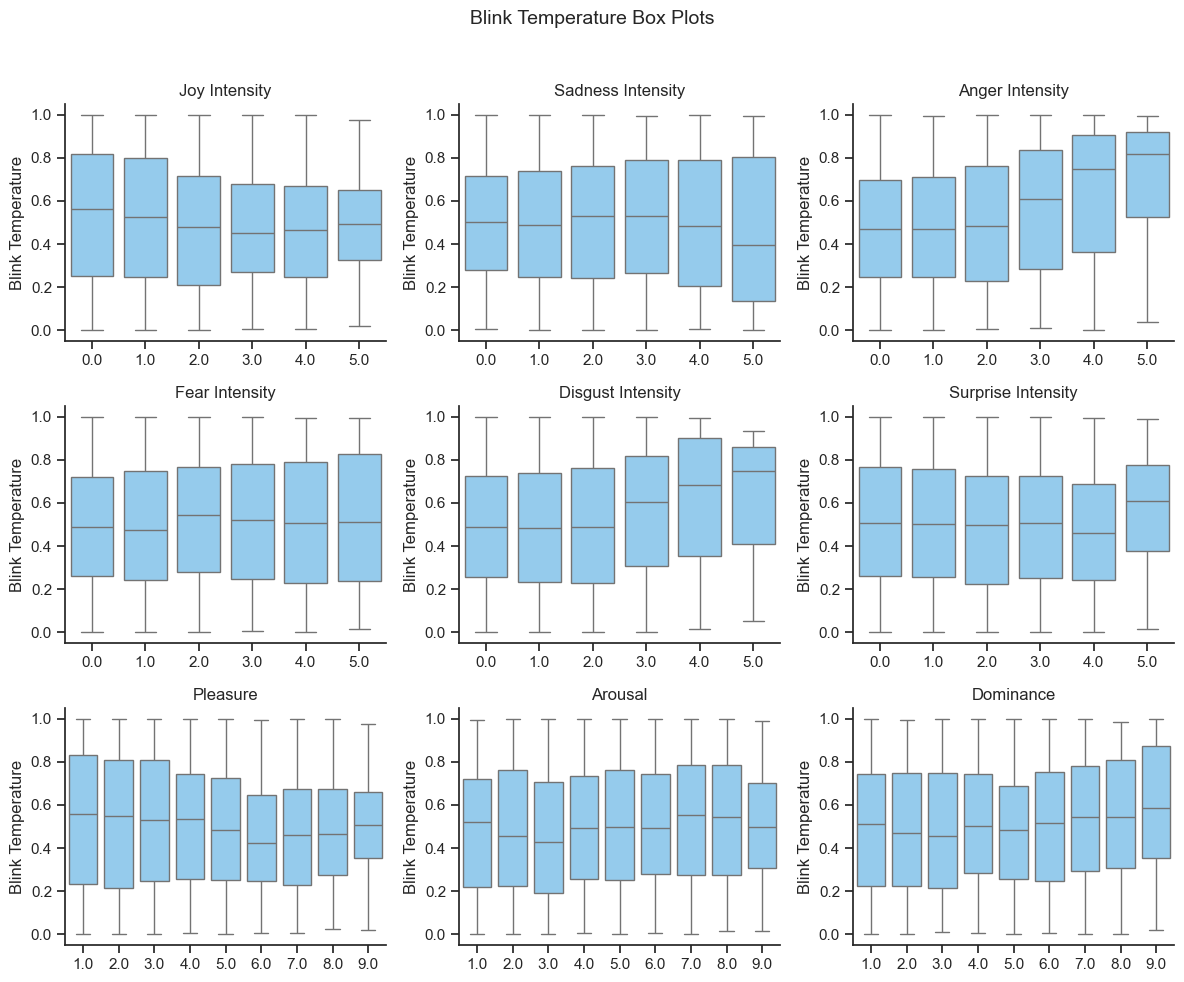

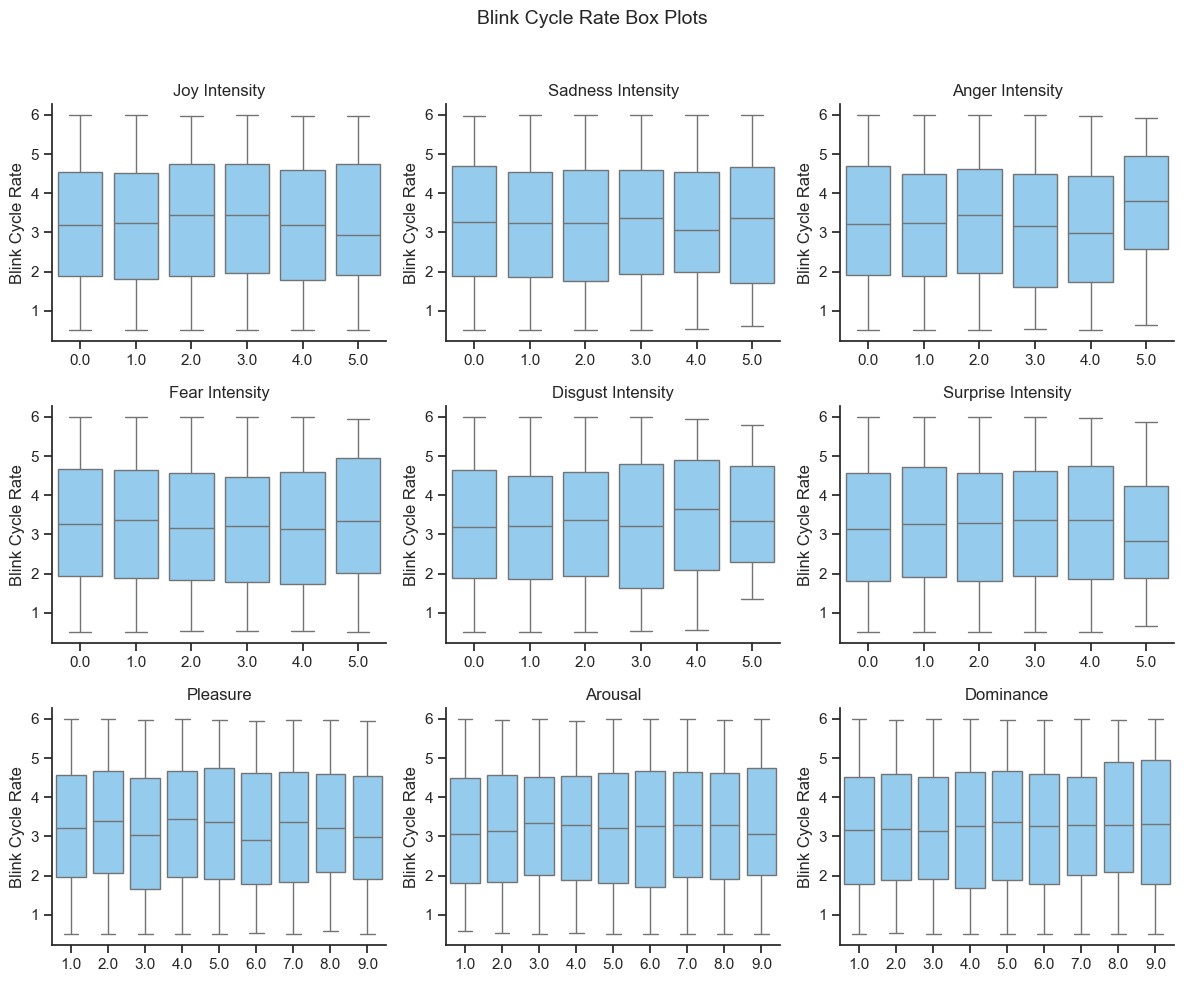

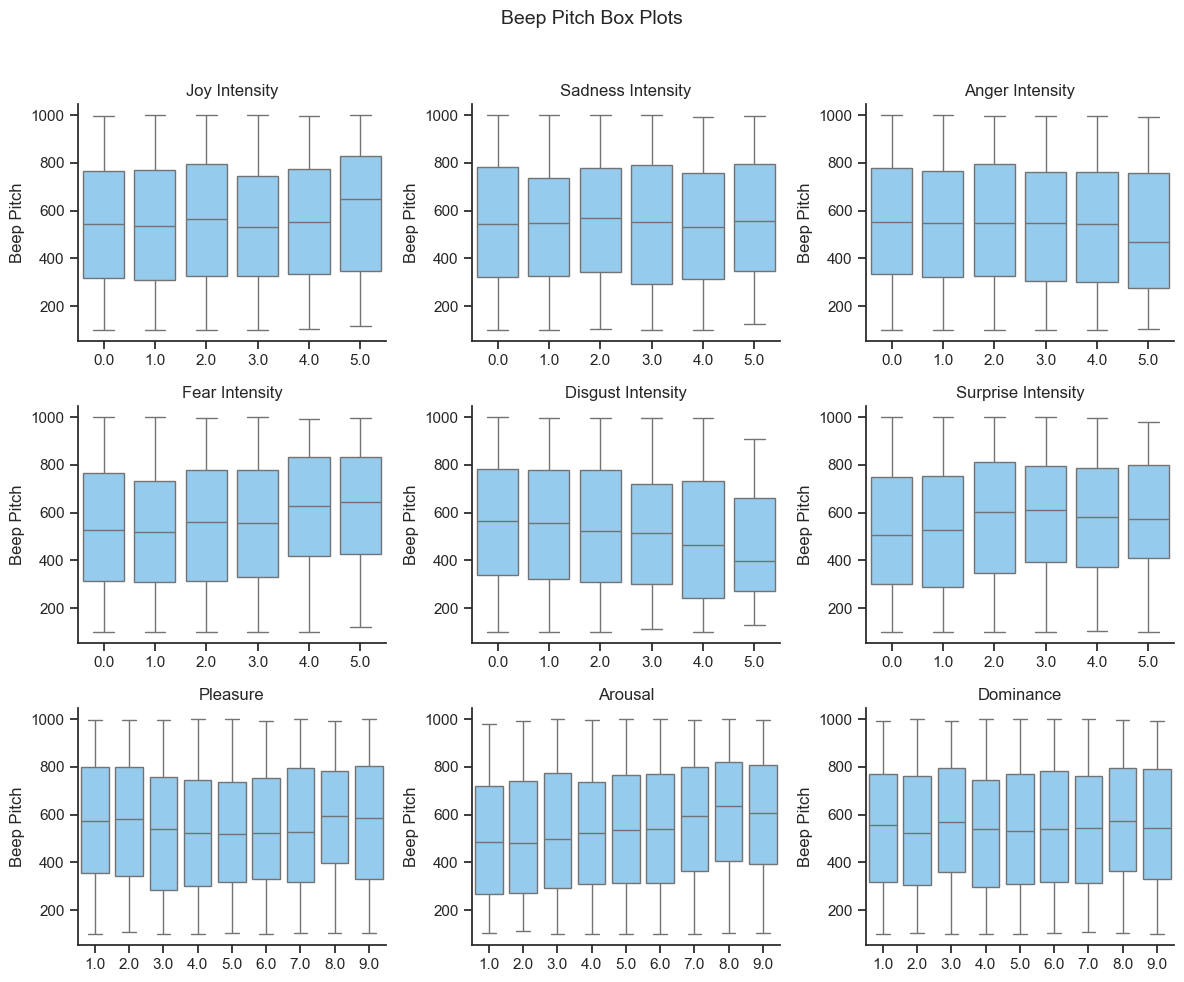

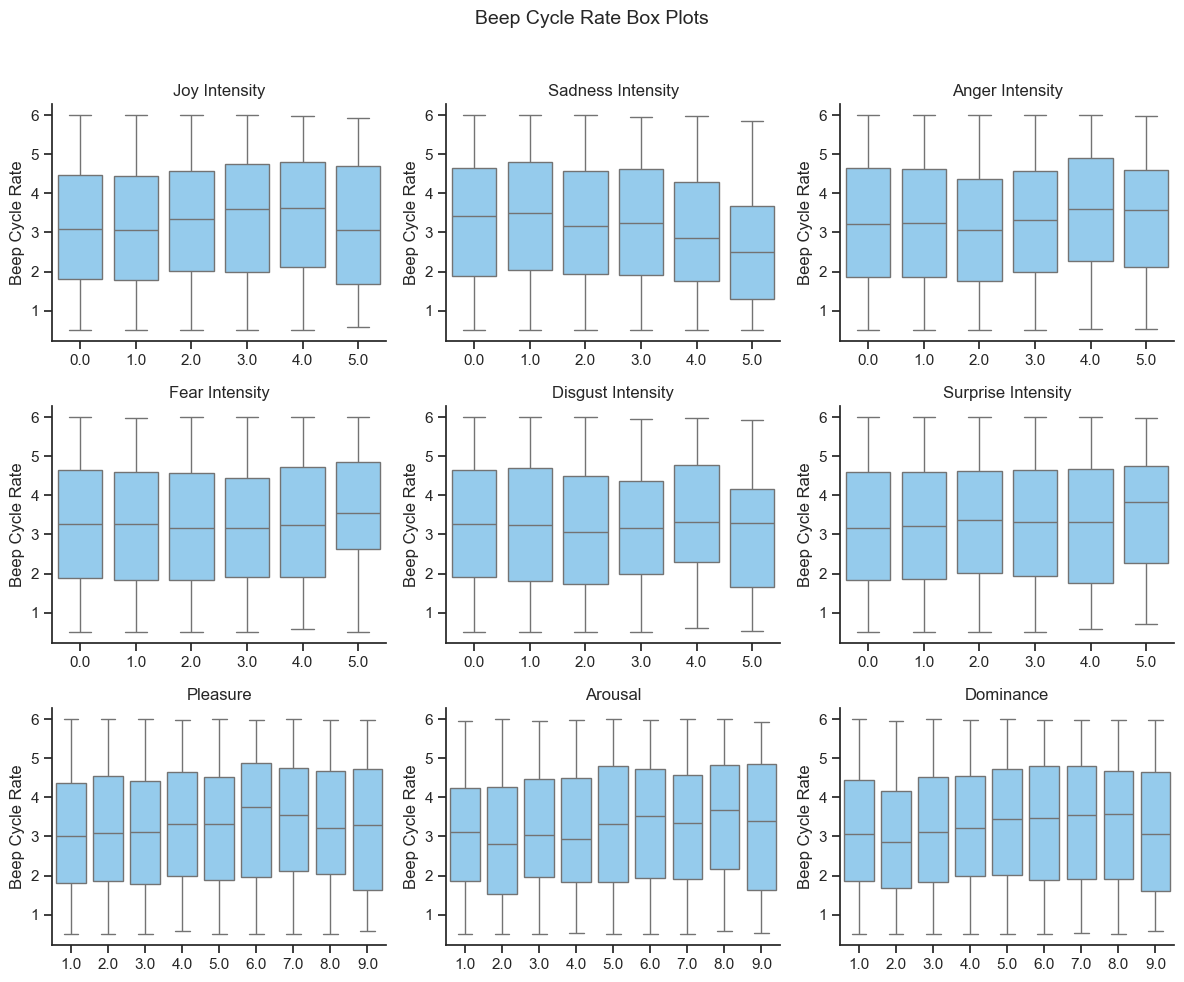

In [23]:
for independent_variable in continuous_independent_variables:
    # Create a new figure for each video
    fig, axes = plt.subplots(3, 3, figsize=(12, 10))
    fig.suptitle(f'{titles[independent_variable]} Box Plots', fontsize=14)
    
    for ax, dependent_variable in zip(axes.flatten(), dependent_numeric_variables):
        sns.boxplot(data=df, x=dependent_variable, y=independent_variable, ax=ax, color='lightskyblue')
        ax.set_title(titles[dependent_variable])
        ax.set_xlabel('')
        ax.set_ylabel(titles[independent_variable])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [24]:
# for video in range(1, 513):
#     fig, axes = plt.subplots(3, 3, figsize=(12, 6))
#     fig.suptitle(f'Video {video}', fontsize=14)

#     for ax, dependent_variable in zip(axes.flatten(), dependent_categorical_variables):
#         # Filter data for current video
#         video_data = df.xs(video, level='video_id')

#         if not video_data[dependent_variable].dropna().empty:
#             # Boxplot with outliers
#             sns.boxplot(data=video_data, x=dependent_variable, ax=ax, color='lightskyblue')

#             # Overlay with a swarmplot to show individual points
#             sns.swarmplot(data=video_data, x=dependent_variable, ax=ax, color='black', alpha=0.5)

#             ax.set_title(titles[dependent_variable])
#             ax.set_xlabel('')
#             ax.set_ylabel('')
#         else:
#             ax.set_title(titles[dependent_variable] + " (No data)")
#             ax.set_xlabel('')
#             ax.set_ylabel('')

#     plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout
#     plt.show()

In [25]:
# Prepare the outlier counts DataFrame
participant_ids = df.index.get_level_values('participant_id').unique()
outlier_counts = pd.DataFrame(0, index=participant_ids, columns=dependent_numeric_variables)

for video in range(1, 513):
    # Extract data for this video and make a copy
    video_data = df.xs(video, level='video_id').copy()

    for dependent_variable in dependent_numeric_variables:
        if dependent_variable in video_data.columns:
            # Ensure data is not NA
            clean_data = video_data[dependent_variable].dropna()

            # Compute the quantiles and IQR only if data is present
            if not clean_data.empty:
                q1 = clean_data.quantile(0.25)
                q3 = clean_data.quantile(0.75)
                iqr = q3 - q1
                lower_bound = q1 - 1.5 * iqr
                upper_bound = q3 + 1.5 * iqr

                # Identify outliers
                outliers = video_data[(video_data[dependent_variable] < lower_bound) | 
                                      (video_data[dependent_variable] > upper_bound)]

                # Count outliers per participant
                for participant in outliers.index:
                    outlier_counts.loc[participant, dependent_variable] += 1

# Filling NaN with 0s for participants with no outliers
outlier_counts.fillna(0, inplace=True)
# Cast all columns to integers
outlier_counts = outlier_counts.astype(int)
# Get the total number of outliers per participant
outlier_counts['total'] = outlier_counts.sum(axis=1)

In [26]:
outlier_counts[outlier_counts.total > 9]

,joy_intensity,sadness_intensity,anger_intensity,fear_intensity,disgust_intensity,surprise_intensity,pleasure,arousal,dominance,total
participant_id,,,,,,,,,,
58aca85e0da7f10001de92d4,0,2,3,2,2,1,1,0,0,11
5ea597859b1fb6594ac2b470,2,0,0,2,1,1,0,3,1,10
5f0cfeef098f1e53ff201909,1,2,0,2,1,3,2,2,1,14
5f0f7fe1d7ad1c000b42d091,0,1,4,1,3,1,0,0,0,10
63d3fb730f03adf8b4a28a37,0,1,2,0,3,2,0,0,2,10
645920abcee1cd09e70057cd,1,1,0,0,1,0,2,1,4,10
6508518b906002118153f087,2,2,3,0,1,1,1,0,0,10
653fcb1b0f5d689c00a97629,1,1,2,1,2,1,1,1,1,11
654983b42d3870e2a88c6fe4,2,1,1,1,0,1,3,1,0,10


In [27]:
corr_matrix = df[independent_variables + dependent_numeric_variables].corr(method='pearson')

In [28]:
corr_matrix

,wander_speed,wander_roundness,wander_cycle_rate,blink_temperature,blink_slope,blink_cycle_rate,beep_pitch,beep_slope,beep_cycle_rate,joy_intensity,sadness_intensity,anger_intensity,fear_intensity,disgust_intensity,surprise_intensity,pleasure,arousal,dominance
wander_speed,1.000000,0.001018,-0.000895,-0.000025,-0.003700,0.007143,0.004331,-0.001602,0.002975,0.051119,-0.128117,0.100160,0.075410,0.018700,0.154537,0.061931,0.313366,0.135339
wander_roundness,0.001018,1.000000,0.000404,-0.009567,0.003861,-0.000199,0.004552,0.003076,0.000845,0.028775,0.018561,-0.044183,-0.091267,-0.018740,-0.109813,0.038517,-0.098539,0.001411
wander_cycle_rate,-0.000895,0.000404,1.000000,-0.004262,0.003331,-0.001382,-0.003006,-0.002758,-0.001115,-0.042876,0.021679,0.016529,0.073290,0.025746,-0.011452,-0.067700,-0.001850,-0.074002
blink_temperature,-0.000025,-0.009567,-0.004262,1.000000,0.004462,-0.003280,-0.000811,-0.002585,-0.000054,-0.089789,-0.007745,0.154728,0.034266,0.082709,-0.016646,-0.075930,0.054777,0.060997
blink_slope,-0.003700,0.003861,0.003331,0.004462,1.000000,0.001686,-0.000040,-0.003786,0.001970,-0.020069,-0.015827,0.004225,-0.018561,-0.007865,-0.026827,-0.007061,-0.001972,-0.005487
blink_cycle_rate,0.007143,-0.000199,-0.001382,-0.003280,0.001686,1.000000,0.003272,-0.001978,0.003554,0.016473,0.001632,-0.003841,-0.005832,0.027398,0.023998,0.001681,0.017779,0.022256
beep_pitch,0.004331,0.004552,-0.003006,-0.000811,-0.000040,0.003272,1.000000,-0.005482,0.000518,0.035318,0.001372,-0.027978,0.083861,-0.061673,0.098558,0.014667,0.101674,-0.003338
beep_slope,-0.001602,0.003076,-0.002758,-0.002585,-0.003786,-0.001978,-0.005482,1.000000,0.001842,0.070292,-0.083637,-0.033325,0.011802,-0.019198,0.096393,0.059520,0.071769,0.035753
beep_cycle_rate,0.002975,0.000845,-0.001115,-0.000054,0.001970,0.003554,0.000518,0.001842,1.000000,0.064128,-0.069716,0.020859,0.012914,0.000344,0.022868,0.053057,0.067047,0.056041
joy_intensity,0.051119,0.028775,-0.042876,-0.089789,-0.020069,0.016473,0.035318,0.070292,0.064128,1.000000,-0.336467,-0.224540,-0.298084,-0.142585,0.229095,0.795528,0.221662,0.344963


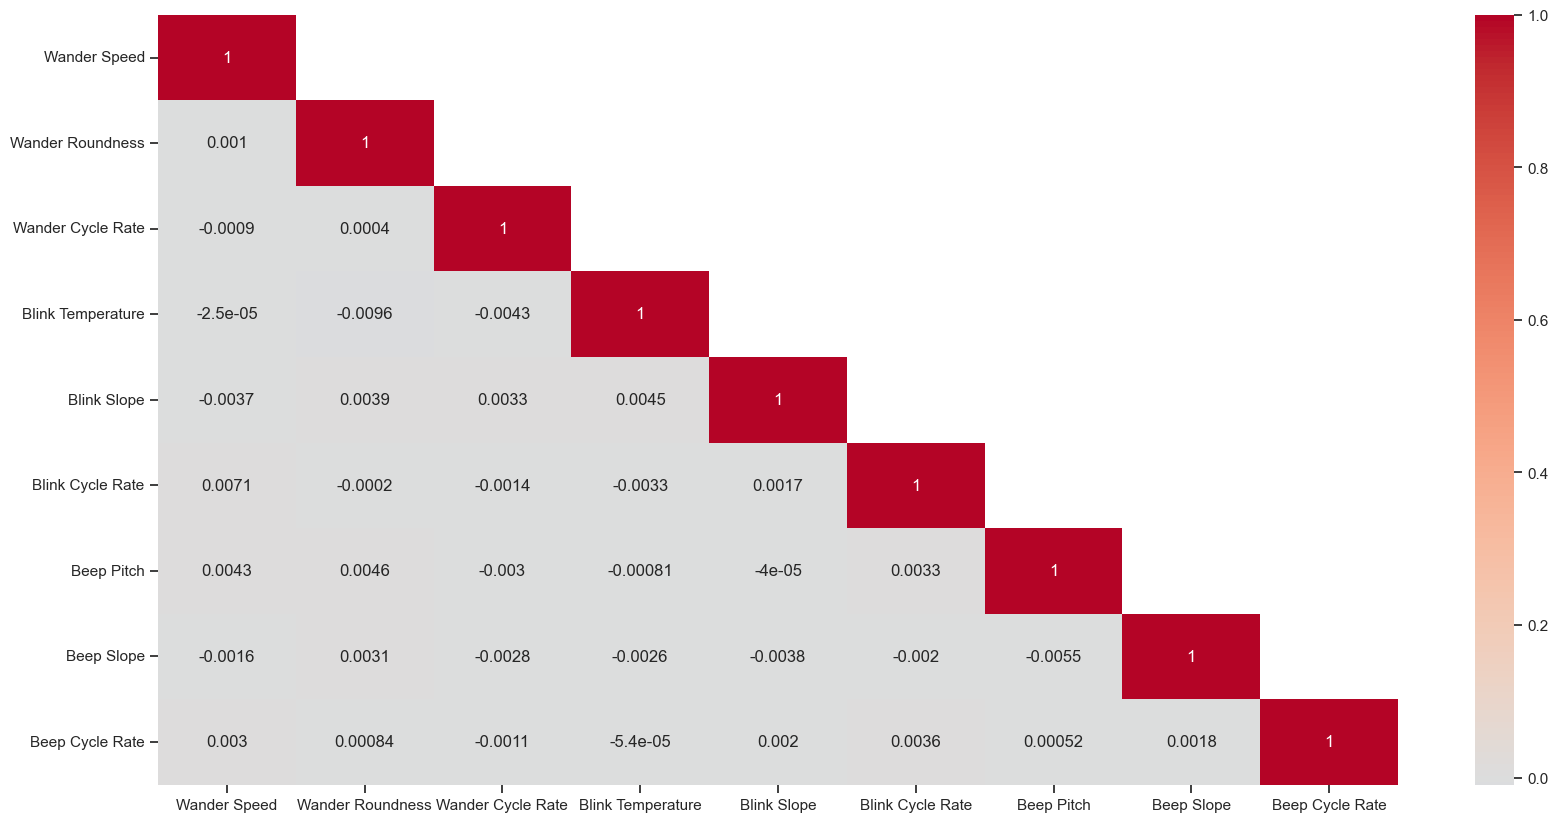

In [29]:
plt.figure(figsize=(20, 10))
ticklabels = [titles[var] for var in independent_variables]
sns.heatmap(corr_matrix.iloc[:num_independent_variables, :num_independent_variables], mask=np.triu(np.ones_like(corr_matrix.iloc[:num_independent_variables, :num_independent_variables], dtype=bool), k=1), annot=True, xticklabels=ticklabels, yticklabels=ticklabels, cmap='coolwarm', center=0)
plt.show()

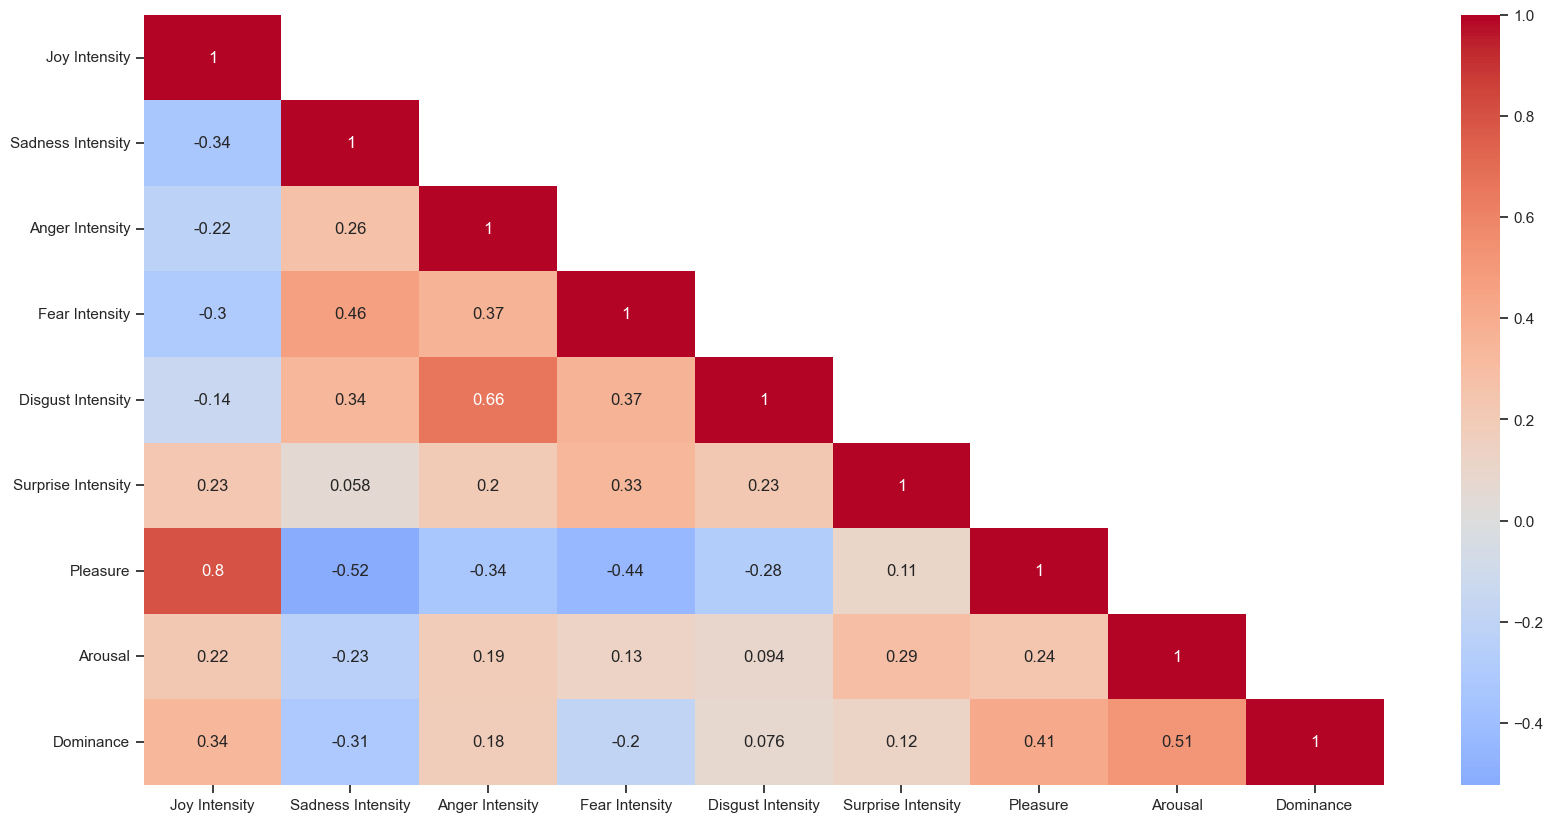

In [30]:
plt.figure(figsize=(20, 10))
ticklabels = [titles[var] for var in dependent_numeric_variables]
sns.heatmap(corr_matrix.iloc[num_independent_variables:, num_independent_variables:], mask=np.triu(np.ones_like(corr_matrix.iloc[num_independent_variables:, num_independent_variables:], dtype=bool), k=1), annot=True, xticklabels=ticklabels, yticklabels=ticklabels, cmap='coolwarm', center=0)
plt.show()

In [31]:
def pearson_r_test(df, independent_variables, dependent_categorical_variables, alpha=0.05, bonferroni_correction=False, benjamini_hochberg_correction=False):
    data = []
    p_values_non_zero = []
    p_values_positive = []
    p_values_negative = []

    if bonferroni_correction and benjamini_hochberg_correction:
        raise Exception("You can only apply one multiple-testing correction.")
    elif bonferroni_correction:
        method = 'bonferroni'
    elif benjamini_hochberg_correction:
        method = 'fdr_bh'
    else:
        method = None  # No correction

    for independent_variable in independent_variables:
        for dependent_variable in dependent_categorical_variables:
            # Calculate Spearman correlation for two-sided test
            rho, p_non_zero = stats.pearsonr(df[independent_variable], df[dependent_variable], alternative='two-sided')
            
            # Calculate Spearman correlation for one-sided tests
            _, p_negative = stats.pearsonr(df[independent_variable], df[dependent_variable], alternative='less')
            _, p_positive = stats.pearsonr(df[independent_variable], df[dependent_variable], alternative='greater')

            # Collect p-values for later adjustment
            p_values_non_zero.append(p_non_zero)
            p_values_positive.append(p_positive)
            p_values_negative.append(p_negative)
            
            # Store the initial results
            row = {'independent_variable': independent_variable, 'dependent_variable': dependent_variable,
                   'correlation': rho, 'p_non_zero': p_non_zero,
                   'is_non_zero': p_non_zero < alpha, 'p_positive': p_positive, 'is_positive': p_positive < alpha / 2, 
                   'p_negative': p_negative, 'is_negative': p_negative < alpha / 2}
            
            data.append(row)
    
    # Convert the list of dictionaries to a DataFrame
    results_df = pd.DataFrame(data)
    
    if method:
        # Apply multiple testing correction
        results_df['is_non_zero'] = multipletests(p_values_non_zero, alpha=alpha, method=method)[0]
        results_df['is_positive'] = multipletests(p_values_positive, alpha=alpha, method=method)[0]
        results_df['is_negative'] = multipletests(p_values_negative, alpha=alpha, method=method)[0]

    return results_df.set_index(['independent_variable', 'dependent_variable'])
    return results_df

In [32]:
correlation_results = pearson_r_test(df, independent_variables, dependent_numeric_variables)

In [33]:
correlation_results

correlation    p_non_zero  \
independent_variable dependent_variable                              
wander_speed         joy_intensity          0.051119  4.048423e-03   
                     sadness_intensity     -0.128117  4.869294e-13   
                     anger_intensity        0.100160  1.677511e-08   
                     fear_intensity         0.075410  2.201188e-05   
                     disgust_intensity      0.018700  2.933117e-01   
...                                              ...           ...   
beep_cycle_rate      disgust_intensity      0.000344  9.845754e-01   
                     surprise_intensity     0.022868  1.987345e-01   
                     pleasure               0.053057  2.849942e-03   
                     arousal                0.067047  1.621116e-04   
                     dominance              0.056041  1.624429e-03   

                                         is_non_zero    p_positive  \
independent_variable dependent_variable                              
wander_speed         joy_intensity              True  2.024212e-03   
                     sadness_intensity          True  1.000000e+00   
                     anger_intensity            True  8.387554e-09   
                     fear_intensity             True  1.100594e-05   
                     disgust_intensity         False  1.466558e-01   
...                                              ...           ...   
beep_cycle_rate      disgust_intensity         False  4.922877e-01   
                     surprise_intensity        False  9.936725e-02   
                     pleasure                   True  1.424971e-03   
                     arousal                    True  8.105581e-05   
                     dominance                  True  8.122146e-04   

                                         is_positive    p_negative  \
independent_variable dependent_variable                              
wander_speed         joy_intensity              True  9.979758e-01   
                     sadness_intensity         False  2.434647e-13   
                     anger_intensity            True  1.000000e+00   
                     fear_intensity             True  9.999890e-01   
                     disgust_intensity         False  8.533442e-01   
...                                              ...           ...   
beep_cycle_rate      disgust_intensity         False  5.077123e-01   
                     surprise_intensity        False  9.006328e-01   
                     pleasure                   True  9.985750e-01   
                     arousal                    True  9.999189e-01   
                     dominance                  True  9.991878e-01   

                                         is_negative  
independent_variable dependent_variable               
wander_speed         joy_intensity             False  
                     sadness_intensity          True  
                     anger_intensity           False  
                     fear_intensity            False  
                     disgust_intensity         False  
...                                              ...  
beep_cycle_rate      disgust_intensity         False  
                     surprise_intensity        False  
                     pleasure                  False  
                     arousal                   False  
                     dominance                 False  

[81 rows x 7 columns]

In [34]:
correlation_results[correlation_results['is_non_zero']]

correlation    p_non_zero  \
independent_variable dependent_variable                              
wander_speed         joy_intensity          0.051119  4.048423e-03   
                     sadness_intensity     -0.128117  4.869294e-13   
                     anger_intensity        0.100160  1.677511e-08   
                     fear_intensity         0.075410  2.201188e-05   
                     surprise_intensity     0.154537  2.410531e-18   
                     pleasure               0.061931  4.952259e-04   
                     arousal                0.313366  5.962654e-73   
                     dominance              0.135339  2.170252e-14   
wander_roundness     anger_intensity       -0.044183  1.299502e-02   
                     fear_intensity        -0.091267  2.759474e-07   
                     surprise_intensity    -0.109813  6.043774e-10   
                     pleasure               0.038517  3.037633e-02   
                     arousal               -0.098539  2.847516e-08   
wander_cycle_rate    joy_intensity         -0.042876  1.593705e-02   
                     fear_intensity         0.073290  3.726440e-05   
                     pleasure              -0.067700  1.397844e-04   
                     dominance             -0.074002  3.127236e-05   
blink_temperature    joy_intensity         -0.089789  4.290552e-07   
                     anger_intensity        0.154728  2.188405e-18   
                     disgust_intensity      0.082709  3.231647e-06   
                     pleasure              -0.075930  1.930476e-05   
                     arousal                0.054777  2.067653e-03   
                     dominance              0.060997  6.020342e-04   
beep_pitch           joy_intensity          0.035318  4.712345e-02   
                     fear_intensity         0.083861  2.351619e-06   
                     disgust_intensity     -0.061673  5.227952e-04   
                     surprise_intensity     0.098558  2.829410e-08   
                     arousal                0.101674  1.015712e-08   
beep_slope           joy_intensity          0.070292  7.662703e-05   
                     sadness_intensity     -0.083637  2.502343e-06   
                     surprise_intensity     0.096393  5.663476e-08   
                     pleasure               0.059520  8.154891e-04   
                     arousal                0.071769  5.390917e-05   
                     dominance              0.035753  4.446809e-02   
beep_cycle_rate      joy_intensity          0.064128  3.095684e-04   
                     sadness_intensity     -0.069716  8.774220e-05   
                     pleasure               0.053057  2.849942e-03   
                     arousal                0.067047  1.621116e-04   
                     dominance              0.056041  1.624429e-03   

                                         is_non_zero    p_positive  \
independent_variable dependent_variable                              
wander_speed         joy_intensity              True  2.024212e-03   
                     sadness_intensity          True  1.000000e+00   
                     anger_intensity            True  8.387554e-09   
                     fear_intensity             True  1.100594e-05   
                     surprise_intensity         True  1.205265e-18   
                     pleasure                   True  2.476129e-04   
                     arousal                    True  2.981327e-73   
                     dominance                  True  1.085126e-14   
wander_roundness     anger_intensity            True  9.935025e-01   
                     fear_intensity             True  9.999999e-01   
                     surprise_intensity         True  1.000000e+00   
                     pleasure                   True  1.518817e-02   
                     arousal                    True  1.000000e+00   
wander_cycle_rate    joy_intensity              True  9.920315e-01   
                     fear_intensity             Tr

In [35]:
correlation_results[correlation_results['is_non_zero'] & correlation_results['is_positive']]

correlation    p_non_zero  \
independent_variable dependent_variable                              
wander_speed         joy_intensity          0.051119  4.048423e-03   
                     anger_intensity        0.100160  1.677511e-08   
                     fear_intensity         0.075410  2.201188e-05   
                     surprise_intensity     0.154537  2.410531e-18   
                     pleasure               0.061931  4.952259e-04   
                     arousal                0.313366  5.962654e-73   
                     dominance              0.135339  2.170252e-14   
wander_roundness     pleasure               0.038517  3.037633e-02   
wander_cycle_rate    fear_intensity         0.073290  3.726440e-05   
blink_temperature    anger_intensity        0.154728  2.188405e-18   
                     disgust_intensity      0.082709  3.231647e-06   
                     arousal                0.054777  2.067653e-03   
                     dominance              0.060997  6.020342e-04   
beep_pitch           joy_intensity          0.035318  4.712345e-02   
                     fear_intensity         0.083861  2.351619e-06   
                     surprise_intensity     0.098558  2.829410e-08   
                     arousal                0.101674  1.015712e-08   
beep_slope           joy_intensity          0.070292  7.662703e-05   
                     surprise_intensity     0.096393  5.663476e-08   
                     pleasure               0.059520  8.154891e-04   
                     arousal                0.071769  5.390917e-05   
                     dominance              0.035753  4.446809e-02   
beep_cycle_rate      joy_intensity          0.064128  3.095684e-04   
                     pleasure               0.053057  2.849942e-03   
                     arousal                0.067047  1.621116e-04   
                     dominance              0.056041  1.624429e-03   

                                         is_non_zero    p_positive  \
independent_variable dependent_variable                              
wander_speed         joy_intensity              True  2.024212e-03   
                     anger_intensity            True  8.387554e-09   
                     fear_intensity             True  1.100594e-05   
                     surprise_intensity         True  1.205265e-18   
                     pleasure                   True  2.476129e-04   
                     arousal                    True  2.981327e-73   
                     dominance                  True  1.085126e-14   
wander_roundness     pleasure                   True  1.518817e-02   
wander_cycle_rate    fear_intensity             True  1.863220e-05   
blink_temperature    anger_intensity            True  1.094202e-18   
                     disgust_intensity          True  1.615823e-06   
                     arousal                    True  1.033826e-03   
                     dominance                  True  3.010171e-04   
beep_pitch           joy_intensity              True  2.356173e-02   
                     fear_intensity             True  1.175809e-06   
                     surprise_intensity         True  1.414705e-08   
                     arousal                    True  5.078559e-09   
beep_slope           joy_intensity              True  3.831351e-05   
                     surprise_intensity         True  2.831738e-08   
                     pleasure                   True  4.077446e-04   
                     arousal                    True  2.695458e-05   
                     dominance                  True  2.223405e-02   
beep_cycle_rate      joy_intensity              True  1.547842e-04   
                     pleasure                   True  1.424971e-03   
                     arousal                    True  8.105581e-05   
                     dominance                  True  8.122146e-04   

                                         is_positive  p_negative  is_negative  
independent_variable dependent_variable

In [36]:
correlation_results[correlation_results['is_non_zero'] & correlation_results['is_negative']]

correlation    p_non_zero  \
independent_variable dependent_variable                              
wander_speed         sadness_intensity     -0.128117  4.869294e-13   
wander_roundness     anger_intensity       -0.044183  1.299502e-02   
                     fear_intensity        -0.091267  2.759474e-07   
                     surprise_intensity    -0.109813  6.043774e-10   
                     arousal               -0.098539  2.847516e-08   
wander_cycle_rate    joy_intensity         -0.042876  1.593705e-02   
                     pleasure              -0.067700  1.397844e-04   
                     dominance             -0.074002  3.127236e-05   
blink_temperature    joy_intensity         -0.089789  4.290552e-07   
                     pleasure              -0.075930  1.930476e-05   
beep_pitch           disgust_intensity     -0.061673  5.227952e-04   
beep_slope           sadness_intensity     -0.083637  2.502343e-06   
beep_cycle_rate      sadness_intensity     -0.069716  8.774220e-05   

                                         is_non_zero  p_positive  is_positive  \
independent_variable dependent_variable                                         
wander_speed         sadness_intensity          True    1.000000        False   
wander_roundness     anger_intensity            True    0.993502        False   
                     fear_intensity             True    1.000000        False   
                     surprise_intensity         True    1.000000        False   
                     arousal                    True    1.000000        False   
wander_cycle_rate    joy_intensity              True    0.992031        False   
                     pleasure                   True    0.999930        False   
                     dominance                  True    0.999984        False   
blink_temperature    joy_intensity              True    1.000000        False   
                     pleasure                   True    0.999990        False   
beep_pitch           disgust_intensity          True    0.999739        False   
beep_slope           sadness_intensity          True    0.999999        False   
beep_cycle_rate      sadness_intensity          True    0.999956        False   

                                           p_negative  is_negative  
independent_variable dependent_variable                             
wander_speed         sadness_intensity   2.434647e-13         True  
wander_roundness     anger_intensity     6.497509e-03         True  
                     fear_intensity      1.379737e-07         True  
                     surprise_intensity  3.021887e-10         True  
                     arousal             1.423758e-08         True  
wander_cycle_rate    joy_intensity       7.968526e-03         True  
                     pleasure            6.989219e-05         True  
                     dominance           1.563618e-05         True  
blink_temperature    joy_intensity       2.145276e-07         True  
                     pleasure            9.652379e-06         True  
beep_pitch           disgust_intensity   2.613976e-04         True  
beep_slope           sadness_intensity   1.251171e-06         True  
beep_cycle_rate      sadness_intensity   4.387110e-05         True

In [37]:
correlation_results_array = correlation_results.correlation.to_numpy()
annot = correlation_results_array.astype(str)
indexed_correlation_results = correlation_results.reset_index()
significance_mask = indexed_correlation_results[indexed_correlation_results['is_non_zero'] & (indexed_correlation_results['is_positive'] | indexed_correlation_results['is_negative'])].index

# Apply asterisks to significant correlations
for i in range(len(correlation_results_array)):
    if i in significance_mask:
        annot[i] = f'{correlation_results_array[i]:.3f}*'
    else:
        annot[i] = f'{correlation_results_array[i]:.3f}'

annot = annot.reshape(num_independent_variables, num_dependent_numeric_variables).T

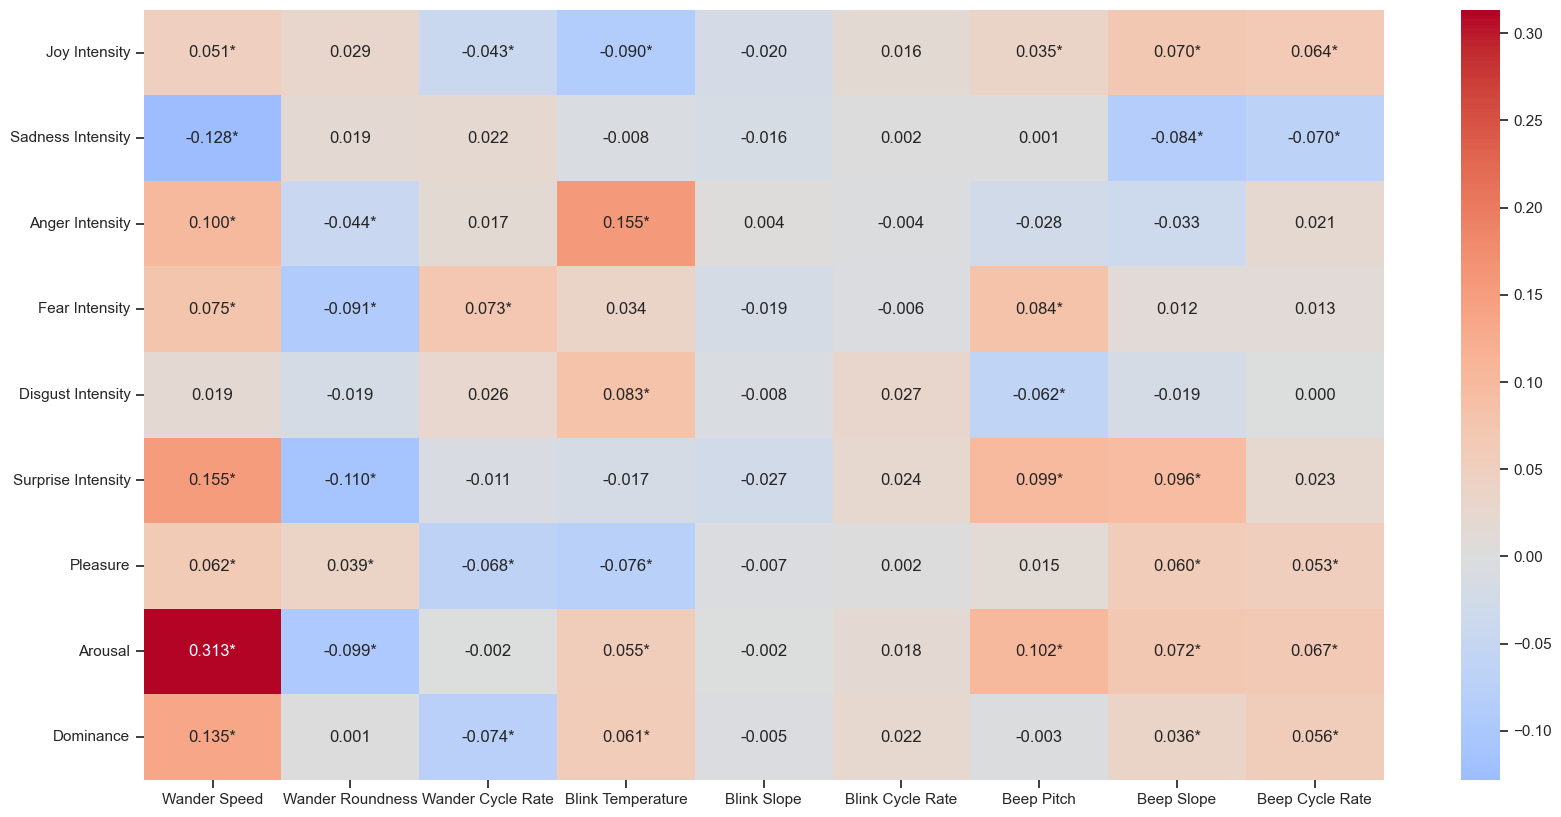

In [38]:
plt.figure(figsize=(20, 10))
xticklabels = [titles[var] for var in independent_variables]
yticklabels = [titles[var] for var in dependent_numeric_variables]
sns.heatmap(corr_matrix.iloc[num_independent_variables:, :num_independent_variables], annot=annot, xticklabels=xticklabels, yticklabels=yticklabels, cmap='coolwarm', fmt='', center=0)
plt.show()

In [39]:
mask = np.array([True] * num_independent_variables * num_dependent_numeric_variables)
mask[significance_mask] = False
mask = mask.reshape(num_independent_variables, num_dependent_numeric_variables).T

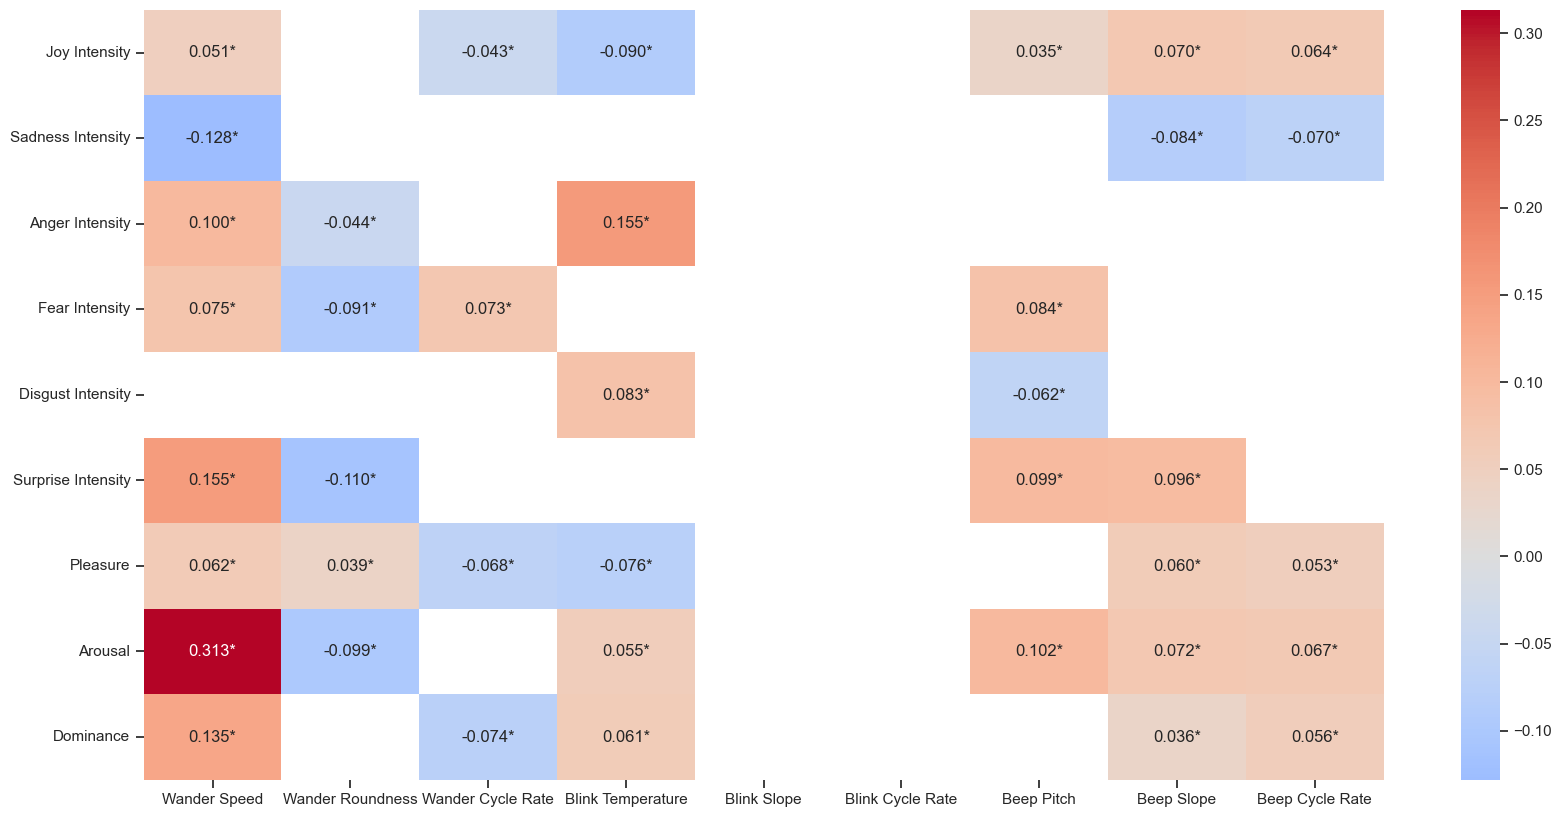

In [40]:
plt.figure(figsize=(20, 10))
xticklabels = [titles[var] for var in independent_variables]
yticklabels = [titles[var] for var in dependent_numeric_variables]
sns.heatmap(corr_matrix.iloc[num_independent_variables:, :num_independent_variables], annot=annot, xticklabels=xticklabels, yticklabels=yticklabels, cmap='coolwarm', fmt='', mask=mask, center=0)
plt.show()

In [41]:
# Prepare the data
data = df.copy()
output = ['arousal']

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(data[independent_variables].values)
y = data[output].values

# Apply PCA for feature reduction (optional)
pca = PCA(n_components=0.95)  # retain 95% of variance
X_pca = pca.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

Average MSE of the model on train data: 3.86
Average MSE of the model on test data: 3.95


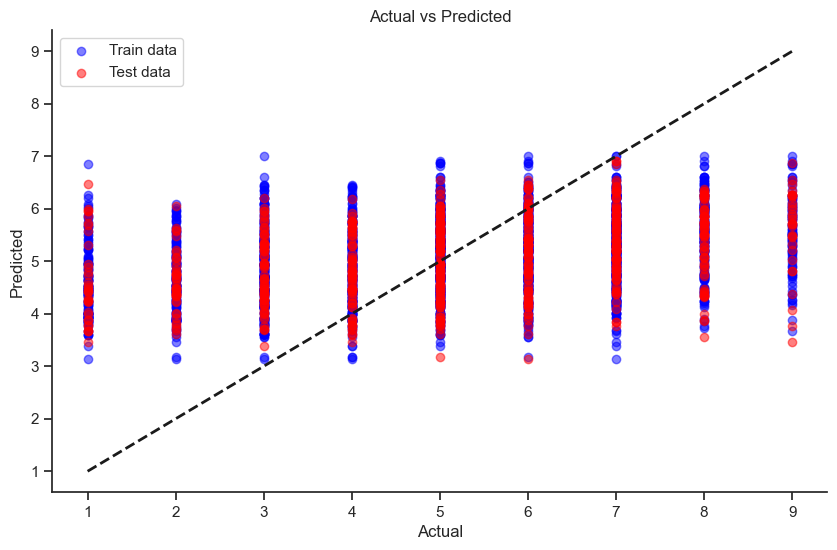

In [42]:
# Define the linear regression model
linear_reg_model = LinearRegression()

# Train the model
linear_reg_model.fit(X_train, y_train)

# Predict on training and test data
y_train_pred = linear_reg_model.predict(X_train)
y_test_pred = linear_reg_model.predict(X_test)

# Calculate mean squared error
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f'Average MSE of the model on train data: {train_mse:.2f}')
print(f'Average MSE of the model on test data: {test_mse:.2f}')

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))

# Plot train data
plt.scatter(y_train, y_train_pred, color='blue', alpha=0.5, label='Train data')
# Plot test data
plt.scatter(y_test, y_test_pred, color='red', alpha=0.5, label='Test data')

plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

In [43]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Define the neural network
class MultiOutputNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MultiOutputNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(0.5)  # Dropout layer with 50% dropout rate
        self.fc4 = nn.Linear(64, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

# Initialize the model, loss function, and optimizer
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
model = MultiOutputNN(input_dim, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    
    # Calculate the loss
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    train_outputs = model(X_train_tensor)
    test_outputs = model(X_test_tensor)
    
    # Calculate mean squared error for each output and average them
    train_mse = mean_squared_error(y_train, train_outputs.numpy(), multioutput='raw_values')
    test_mse = mean_squared_error(y_test, test_outputs.numpy(), multioutput='raw_values')
    
    avg_train_mse = np.mean(train_mse)
    avg_test_mse = np.mean(test_mse)
    
    print(f'Average MSE of the model on train data: {avg_train_mse:.2f}')
    print(f'Average MSE of the model on test data: {avg_test_mse:.2f}')
    
    # Print MSE for each output
    print('MSE for each output on train data:')
    for i, mse in enumerate(train_mse):
        print(f'Output {i+1}: {mse:.2f}')
    
    print('MSE for each output on test data:')
    for i, mse in enumerate(test_mse):
        print(f'Output {i+1}: {mse:.2f}')


Epoch [10/200], Loss: 28.0972
Epoch [20/200], Loss: 25.4391
Epoch [30/200], Loss: 22.8688
Epoch [40/200], Loss: 20.2749
Epoch [50/200], Loss: 18.3639
Epoch [60/200], Loss: 16.2452
Epoch [70/200], Loss: 14.4964
Epoch [80/200], Loss: 12.8480
Epoch [90/200], Loss: 11.2106
Epoch [100/200], Loss: 10.1127
Epoch [110/200], Loss: 8.9391
Epoch [120/200], Loss: 7.9857
Epoch [130/200], Loss: 7.3552
Epoch [140/200], Loss: 6.5289
Epoch [150/200], Loss: 6.1410
Epoch [160/200], Loss: 5.8056
Epoch [170/200], Loss: 5.4365
Epoch [180/200], Loss: 5.1901
Epoch [190/200], Loss: 5.0788
Epoch [200/200], Loss: 4.9687
Average MSE of the model on train data: 4.58
Average MSE of the model on test data: 5.34
MSE for each output on train data:
Output 1: 4.58
MSE for each output on test data:
Output 1: 5.34
